In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SUL DATASET**

Il dataset è una versione pre-processata del dataset **OASIS Alzheimer's Detection** (un dataset di immagini MRI del cervello di 461 pazienti) utilizzato per rilevare i segni precoci dell’Alzheimer.

Poiché le immagini MRI sono 3D, sono state divise lungo l'asse z (l'asse della profondità del cervello) in 175 fette e sono state selezionate le fette che vanno dalla 55 esima alla 124 esima al fine di ridurre il numero di immagini e concentrarsi sulle sezioni cerebrali rilevanti per l'analisi della demenza; Questo approccio ha generato immagini 2D per ogni paziente.

Lo stesso approccio è stato utilizzato per le versioni delle MRI con segmentazione delle aree cerebrali offerte da OASIS.

****
****

Le immagini sono classificate in **quattro sottoclassi**, in base alla progressione della malattia:

*   Moderate dementia (affetto da demenza)

*   Very mild dementia (affetto da demenza molto lieve)
* Mild dementia (affetto da demenza lieve)
* Non-demented (non affetto da demenza)


*La classificazione dei pazienti è stata effettuata sulla base delle valutazioni CDR (Clinical Dementia Rating), un punteggio che valuta la severità della demenza.*



In [3]:
#estrazione dataset
import zipfile
import os

zip_path = "/content/drive/My Drive/Alzheimer-detection-project/oasis 1.zip"
extract_folder = "/content/Alzheimer-detection-project"

os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("File estratti:", os.listdir(extract_folder))


File estratti: ['__MACOSX', 'oasis 1']


In [4]:
oasis1_path = os.path.join(extract_folder, "oasis 1")
print(os.listdir(oasis1_path))

['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very Mild Dementia', '.DS_Store']


In [5]:
category_path = os.path.join(oasis1_path, "Moderate Dementia")
print(os.listdir(category_path))

['mri segmented', 'mri scan', '.DS_Store']


In [6]:
mri_path= os.path.join(category_path, "mri scan")
print(os.listdir(mri_path))

['OAS1_0351MR1 ', '.DS_Store', 'OAS1_0308MR1 ']


Moderate Dementia: 140 immagini mri segmentate
Mild Dementia: 1960 immagini mri segmentate
Very Mild Dementia: 5006 immagini mri segmentate
Non Demented: 23520 immagini mri segmentate
Moderate Dementia: 140 immagini mri 
Mild Dementia: 1960 immagini mri 
Very Mild Dementia: 5006 immagini mri 
Non Demented: 23520 immagini mri 


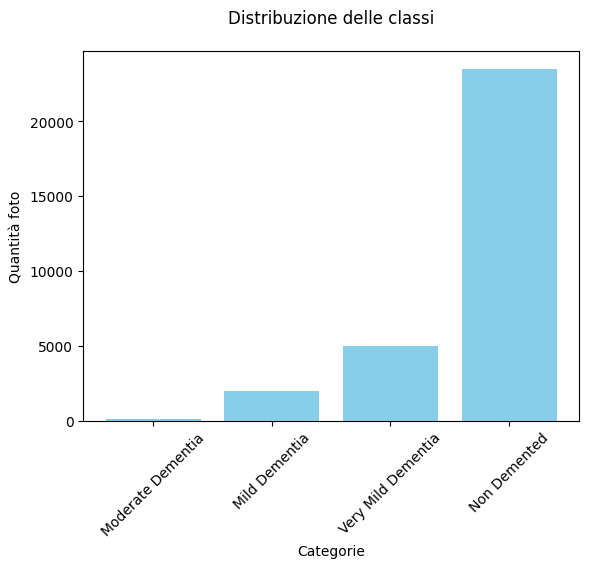

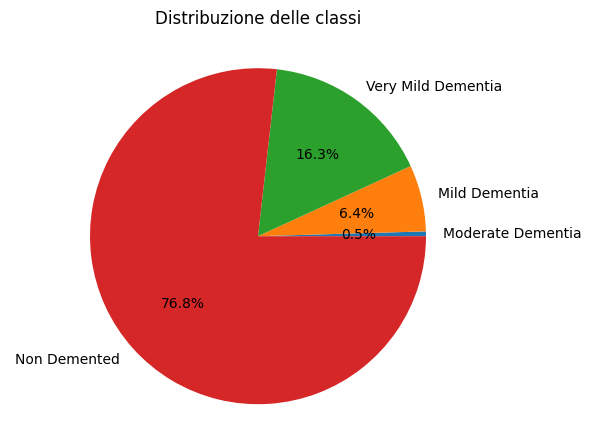

In [50]:
# numero di immagini per categoria - grafico di distriibuzione delle classi
import matplotlib.pyplot as plt

categories = ['Moderate Dementia', 'Mild Dementia', 'Very Mild Dementia', 'Non Demented']
somma=0

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      if patient == ".DS_Store":                                      #aggiustare dataset rimuovendo queste cartelle
        continue
      patient_path=os.path.join(mri_segmented_path, patient)
      file_path=os.path.join(patient_path, '.DS_Store')
      if os.path.isfile(file_path):
        os.remove(file_path)
      images= os.listdir(os.path.join(mri_segmented_path, patient))
      somma=somma+len(images)
    print(f"{category}: {somma} immagini mri segmentate")
    somma=0

valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      if patient == ".DS_Store":                                      #aggiustare dataset rimuovendo queste cartelle
        continue
      patient_path=os.path.join(mri_path, patient)
      file_path=os.path.join(patient_path, '.DS_Store')
      if os.path.isfile(file_path):
        os.remove(file_path)
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f"{category}: {somma} immagini mri ")
    valori.append(somma)
    somma=0

# visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()

print(f" ")
# visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()





OAS1_0351MR1 : paziente 
OAS1_0351MR1 seg: paziente segmentato


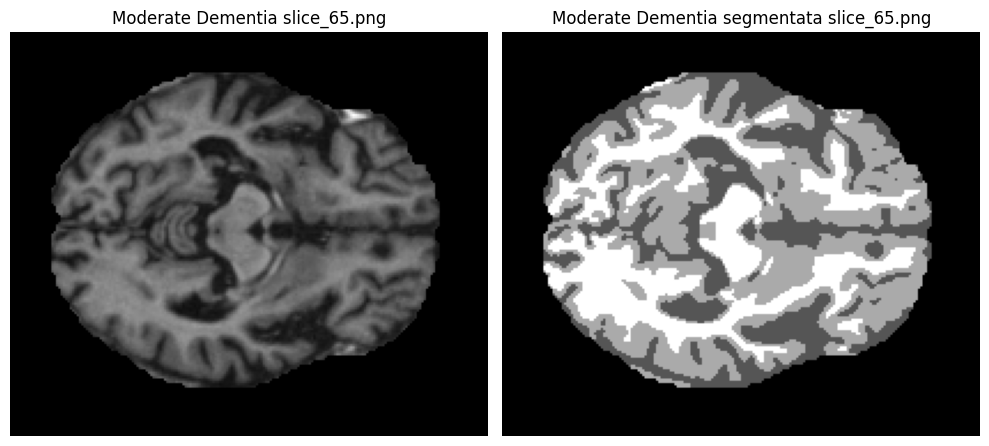

OAS1_0073MR1 : paziente 
OAS1_0073MR1 seg: paziente segmentato


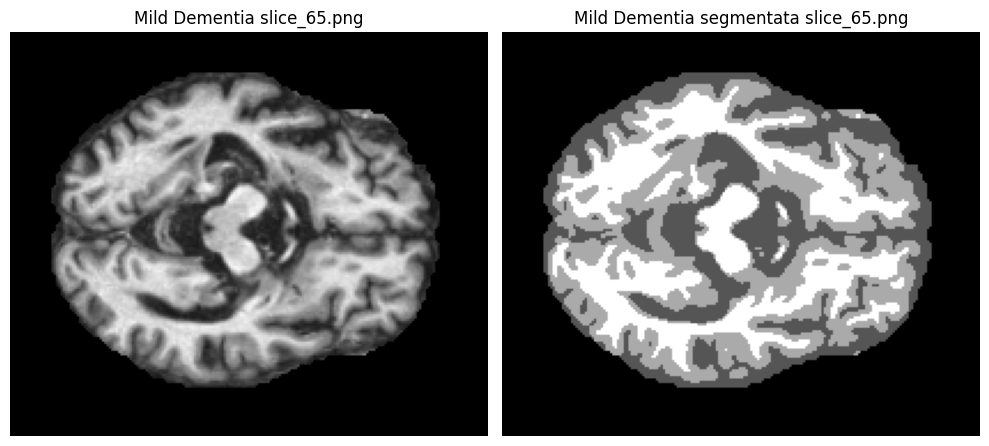

OAS1_0164MR1 : paziente 
OAS1_0164MR1 seg: paziente segmentato


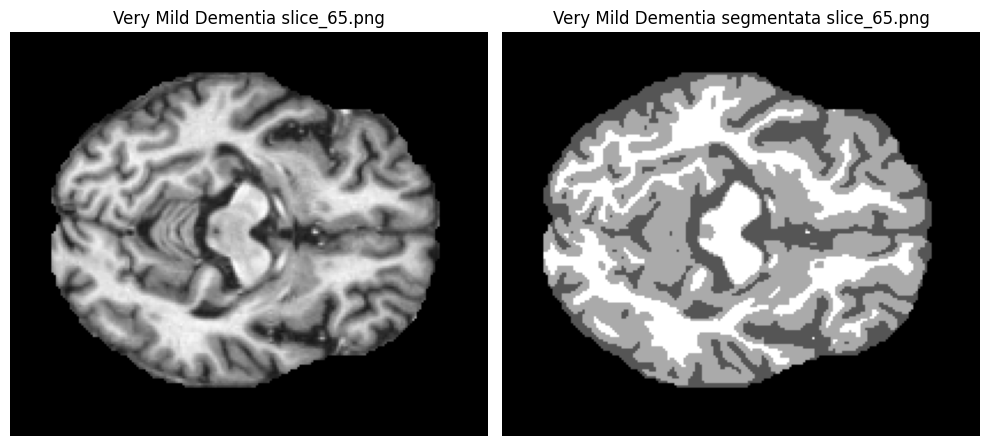

OAS1_0168MR1 : paziente 
OAS1_0168MR1 seg: paziente segmentato


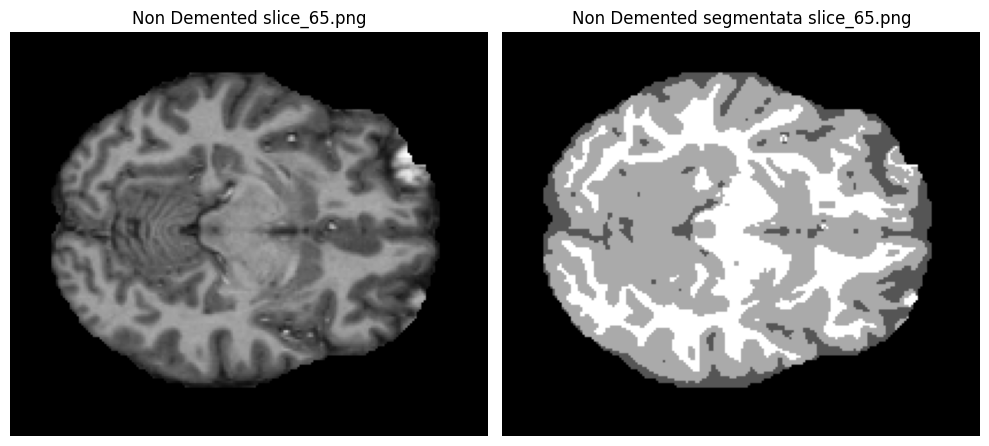

In [59]:
#visualizzazione di immagini a campione

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#scelta della slice
category_path = os.path.join(oasis1_path, 'Non Demented')
mri_path= os.path.join(category_path, 'mri scan')
folders=os.listdir(mri_path)
folder_to_exclude='.DS_Store'                                         #aggiustare dataset rimuovendo queste cartelle
folders = [folder for folder in folders if folder != folder_to_exclude]
random_folder = random.choice(folders)
patient_path= os.path.join(mri_path, random_folder)
random_slice = random.choice(os.listdir(patient_path))

for category in categories:
  category_path = os.path.join(oasis1_path, category)
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  mri_path= os.path.join(category_path, 'mri scan')
  folders=os.listdir(mri_path)
  folder_to_exclude='.DS_Store'                                       #aggiustare dataset rimuovendo queste cartelle
  folders = [folder for folder in folders if folder != folder_to_exclude]
  random_folder = random.choice(folders)
  print(f"{random_folder}: paziente ")
  random_folder_seg= f"{random_folder}seg"
  print(f"{random_folder_seg}: paziente segmentato")                  #aggiustare dataset uniformando i nomi delle cartelle

  patient_path= os.path.join(mri_path, random_folder)
  patient_path_seg= os.path.join(mri_segmented_path, random_folder_seg)

  img_path = os.path.join(patient_path, random_slice)
  img = mpimg.imread(img_path)
  img_seg_path = os.path.join(patient_path_seg, random_slice)
  img_seg = mpimg.imread(img_seg_path)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(img)
  axes[0].set_title(f"{category} {random_slice}")
  axes[0].axis('off')

  axes[1].imshow(img_seg)
  axes[1].set_title(f"{category} segmentata {random_slice}")
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()



In [55]:
# check dimensioni e canali
from PIL import Image

images_dimentions=set()
images_channels=set()

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      if patient == ".DS_Store":                                      #aggiustare dataset rimuovendo queste cartelle
        continue
      patient_path=os.path.join(mri_path, patient)
      file_path=os.path.join(patient_path, '.DS_Store')
      if os.path.isfile(file_path):
        os.remove(file_path)
      images= os.listdir(os.path.join(mri_path, patient))

      for image in images:
        image_path=os.path.join(patient_path, image)
        i=Image.open(image_path)
        w,h=i.size
        images_dimentions.add((w, h))

        mode = i.mode
        images_channels.add(mode)
if len(images_dimentions) == 1:
  print("tutte le immagini hanno le stesse dimensioni", images_dimentions.pop())
else:
  print("NON tutte le immagini hanno le stesse dimensioni:")
  for dim in images_dimentions:
        print("-", dim)

if len(images_channels) == 1:
    print("tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for mode in images_channels:
        print("-", mode)



tutte le immagini hanno le stesse dimensioni (208, 176)
tutte le immagini hanno lo stesso numero di canali: RGBA
